# Noise Hamming weight and Pearson Correlation

This notebook demonstrates how to guess a floating number using Hamming Weight model.

We generate a random secret floating number. Then we use hamming weight model to guess the number.

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint
from guess_range import *
from batina_guess_number import *

## Visualize HW Behavior

In [2]:
def compute_corr(secret_hw, guess_range, known_inputs, guess_val_size=1000):
    low, high = guess_range
    guess_val = np.arange(low, high, (high - low) / (guess_val_size - 1e-127))
    hw = pd.DataFrame(columns=guess_val,
                        data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_val))
    return hw.corrwith(pd.Series(secret_hw), method='pearson')

In [3]:
guess_range=(-5.0, 5.0)
# the number of guess values in the guess range
guess_val_size=200
# generate the known inputs which is used to test the guess values
input_range = 2
known_inputs = np.random.uniform(-10 ** input_range, 10 ** input_range, 1000)

secret_number = np.random.uniform(guess_range[0], guess_range[1]) 
secret_number = -0.21265
print('secret_number =', secret_number)

secret_number = -0.21265


In [4]:
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
correlations = compute_corr(secret_hw, guess_range, known_inputs, guess_val_size)
correlations_1 = compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size*10))
correlations_2 = compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size/10))
correlations_1.sort_values(ascending=False).iloc[:10]

-0.425    0.326826
-0.210    0.312120
-0.215    0.311876
-0.850    0.304650
-3.400    0.279270
-1.700    0.275515
 0.425    0.270575
-0.225    0.268987
-3.405    0.259394
 0.215    0.253427
dtype: float64

In [5]:
i = correlations_1.sort_values(ascending=False).index
a = np.logical_and((i > 0.62),  (i < 0.63))
b = np.logical_and(a, correlations_1>0.6)
i[b]

Float64Index([], dtype='float64')

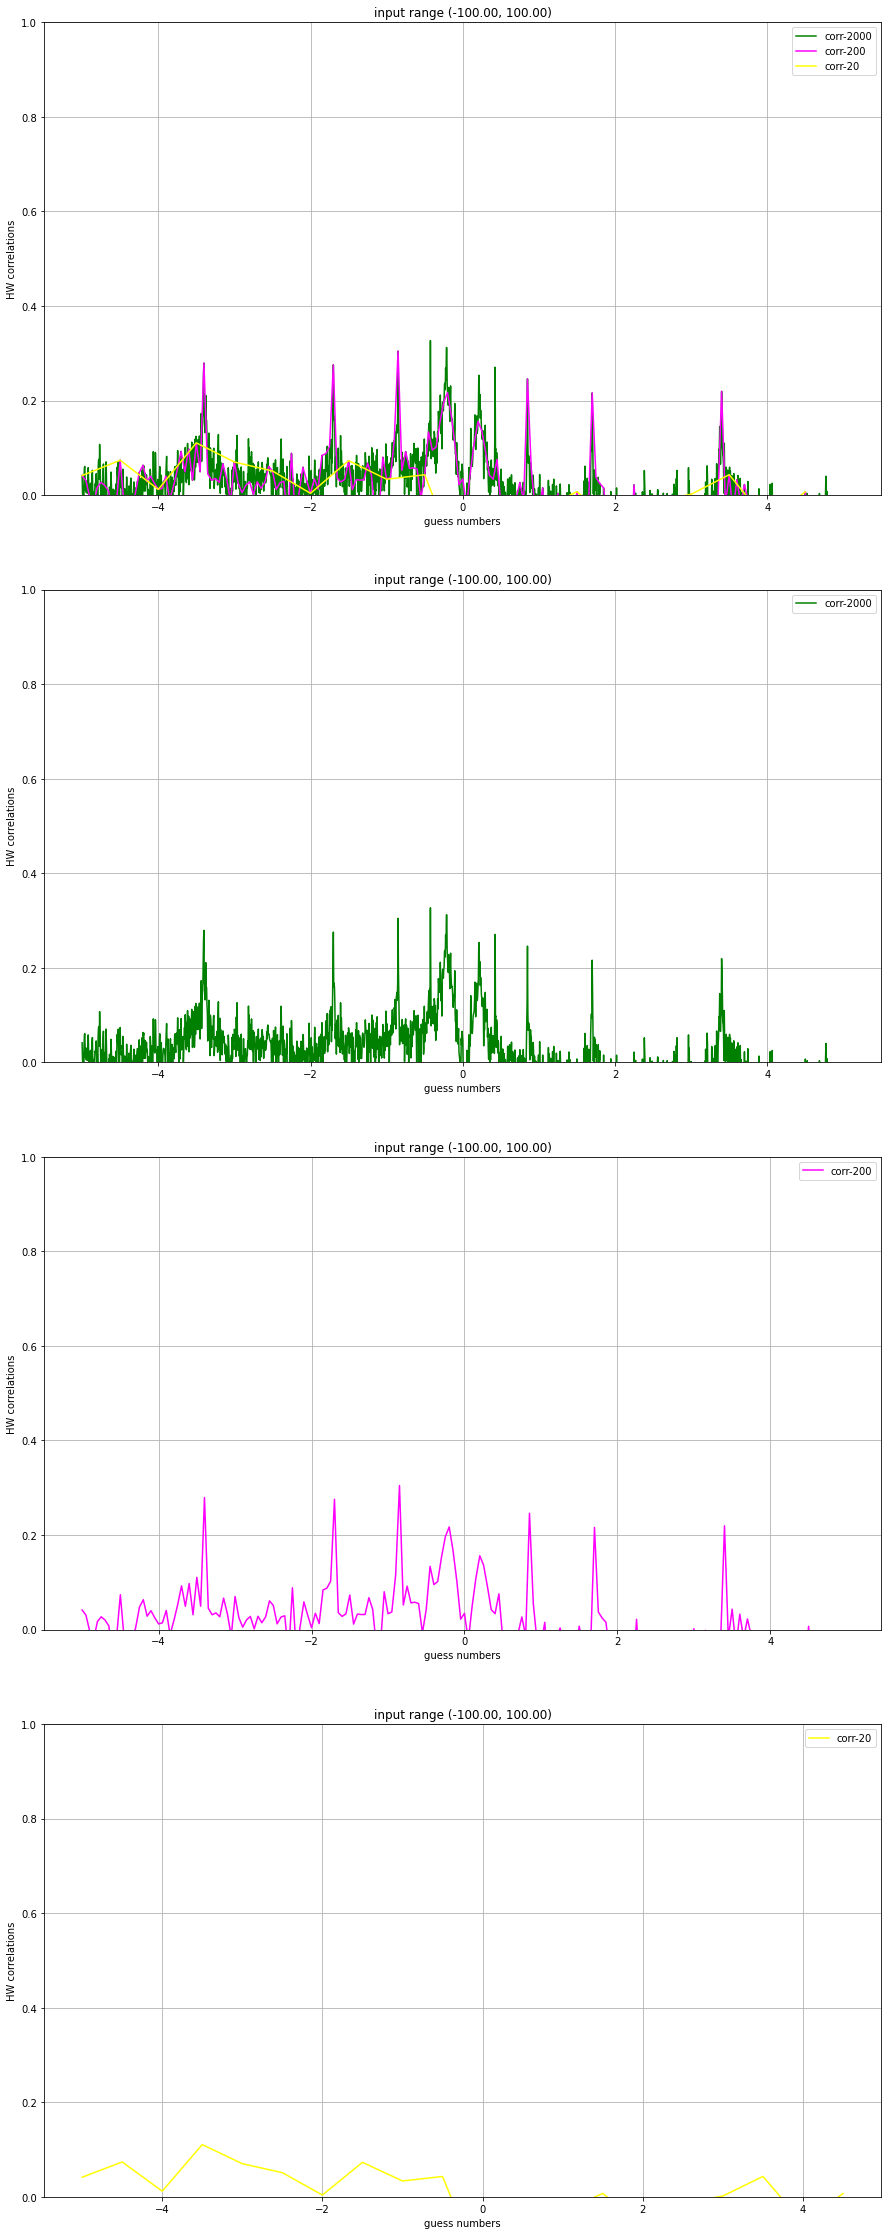

In [6]:
show_secret_line = False


from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 40))
correlations_1.plot(ax=ax[0], label='corr-%s' % correlations_1.shape[0], color='green')
correlations.plot(ax=ax[0], label='corr-%s' % correlations.shape[0], color='magenta')
correlations_2.plot(ax=ax[0], label='corr-%s' % correlations_2.shape[0], color='yellow')

correlations_1.plot(ax=ax[1], label='corr-%s' % correlations_1.shape[0], color='green')

correlations.plot(ax=ax[2], label='corr-%s' % correlations.shape[0], color='magenta')

correlations_2.plot(ax=ax[3], label='corr-%s' % correlations_2.shape[0], color='yellow')

for a in ax:
    if show_secret_line and ((guess_range[0] <= secret_number) and (secret_number < guess_range[1])):
        a.vlines(secret_number, min(0, correlations.min()), max(correlations.max(),0), color='red', label='secret value')
    a.set_ylim(0.0, 1.0)
    a.legend()
    a.grid(True)
    a.set_xlabel('guess numbers')
    a.set_ylabel('HW correlations')
    a.set_title('input range (%.02f, %.02f)' % (-10 ** input_range, 10 ** input_range))
    
plt.show()

## Correlation of mantissa

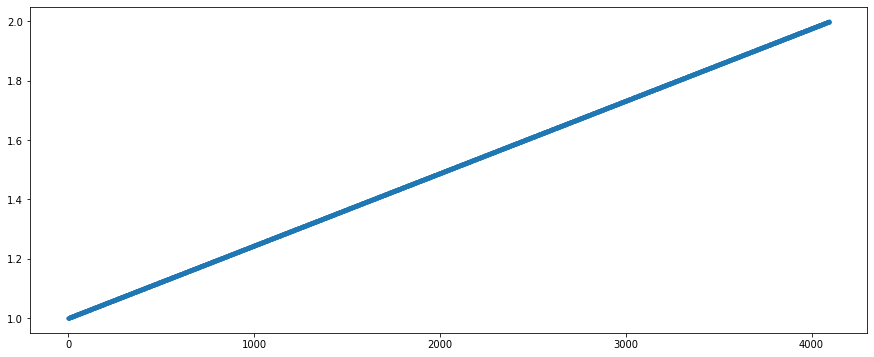

In [7]:
mantissa_nbits = 12
guess_numbers = build_guess_values(component='mantissa', mantissa_nbits=mantissa_nbits, guess_range=guess_range)
pd.Series(guess_numbers).sort_values().reset_index(drop=True).plot(figsize=(15,6), marker='.')

In [8]:
total_mantissa_nbits = 23
known_inputs = build_input_values(mantissa_nbits=mantissa_nbits, component='mantissa')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)

In [9]:
%%time
mantisa_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

CPU times: user 20.9 s, sys: 572 ms, total: 21.4 s
Wall time: 21.4 s


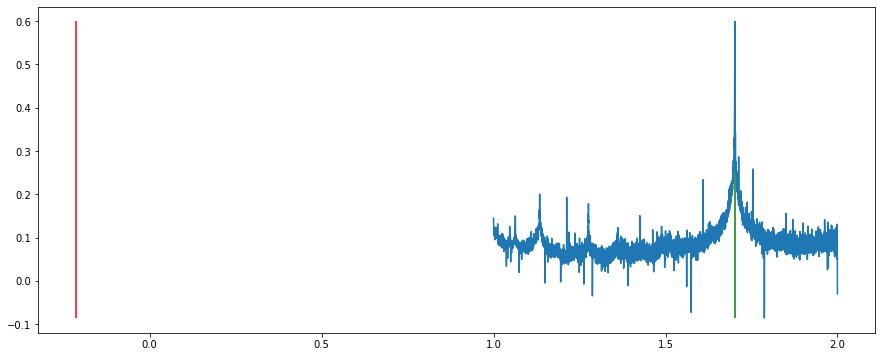

In [10]:
ax = mantisa_corr.sort_index().plot(figsize=(15,6))
ax.vlines(mantisa_corr.idxmax(), mantisa_corr.min(), mantisa_corr.max(), color='green')
ax.vlines(secret_number, mantisa_corr.min(), mantisa_corr.max(), color='red')

In [11]:
mantisa_corr.sort_values(ascending=False).iloc[:10]

1.701172    0.599426
1.701416    0.446206
1.700928    0.430343
1.700684    0.385886
1.701660    0.385636
1.701904    0.365699
1.700195    0.362982
1.700439    0.360790
1.702148    0.344762
1.703125    0.342544
dtype: float64

## Correlation exponent

In [12]:
known_inputs = build_input_values(component='exponent')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)

/home/tvk/programming/others/DPACv4/batina_guess_number.py:39: RuntimeWarning: invalid value encountered in greater_equal
  guess_numbers = y[(lo_range <= y) & (y <= hi_range)]
/home/tvk/programming/others/DPACv4/batina_guess_number.py:39: RuntimeWarning: invalid value encountered in less_equal
  guess_numbers = y[(lo_range <= y) & (y <= hi_range)]


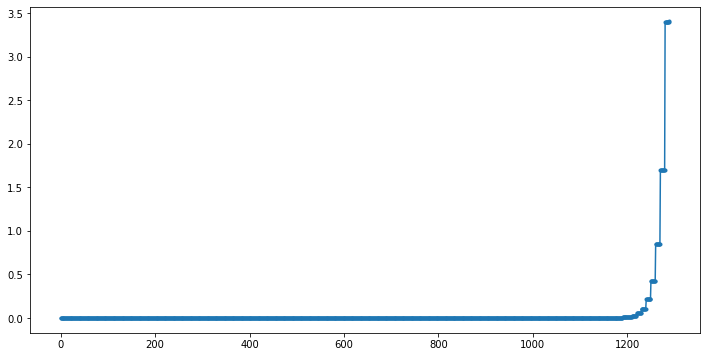

In [13]:
guess_numbers = build_guess_values(component='exponent', numbers=mantisa_corr.sort_values(ascending=False).index[:10], guess_range=guess_range)
pd.Series(guess_numbers).sort_values().reset_index(drop=True).plot(figsize=(12,6), marker='.')

In [14]:
%%time
mantisa_exp_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


CPU times: user 581 ms, sys: 8.03 ms, total: 589 ms
Wall time: 587 ms


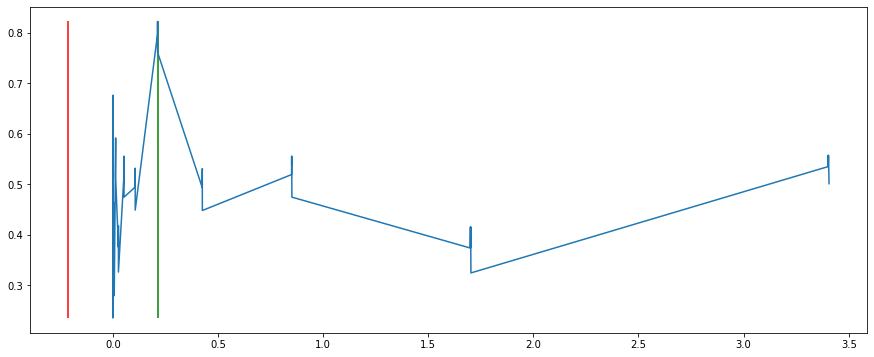

In [15]:
ax = mantisa_exp_corr.sort_index().plot(figsize=(15,6))
ax.vlines(mantisa_exp_corr.idxmax(), mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='green')
ax.vlines(secret_number, mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='red')

In [16]:
mantisa_exp_corr.sort_values(ascending=False).iloc[:10]

0.212616    0.822707
0.212738    0.822707
0.212708    0.811407
0.212769    0.811407
0.212555    0.811407
0.212677    0.811407
0.212585    0.811407
0.212524    0.797551
0.212646    0.797551
0.212891    0.761566
dtype: float64

## Correlation sign

array([ 0.21261597,  0.21273804,  0.21270752,  0.21276855,  0.21255493,
        0.212677  ,  0.21258545,  0.21252441,  0.21264648,  0.21289062,
       -0.21261597, -0.21273804, -0.21270752, -0.21276855, -0.21255493,
       -0.212677  , -0.21258545, -0.21252441, -0.21264648, -0.21289062])

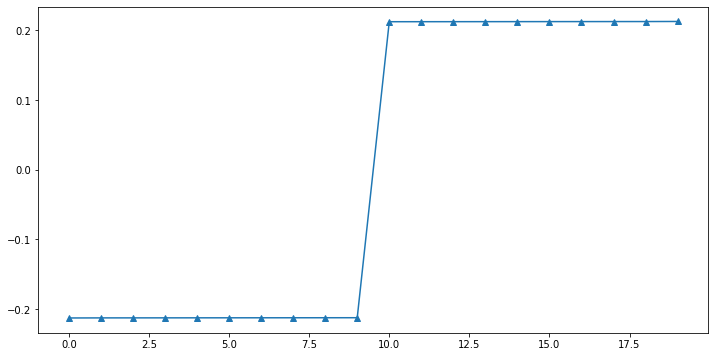

In [17]:
guess_numbers = build_guess_values(component='sign', numbers=mantisa_exp_corr.sort_values(ascending=False).index[:10], guess_range=guess_range)
pd.Series(guess_numbers).sort_values().reset_index(drop=True).plot(figsize=(12,6), marker='^')
guess_numbers

In [18]:
%%time
known_inputs = build_input_values(component='sign')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
full_number_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

CPU times: user 2.37 ms, sys: 3.95 ms, total: 6.32 ms
Wall time: 5.83 ms


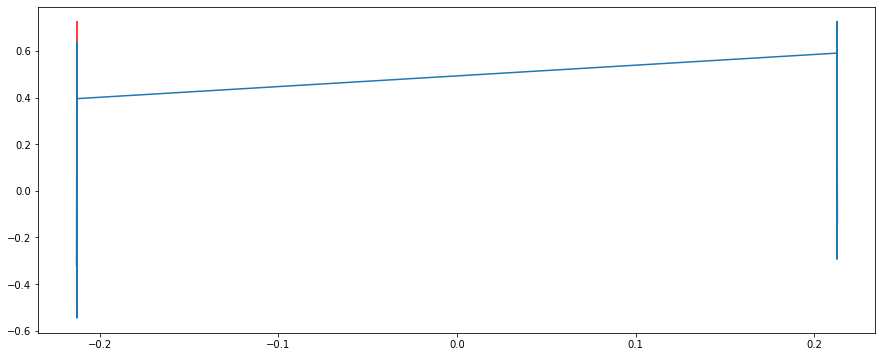

In [19]:
ax = full_number_corr.sort_index().plot(figsize=(15,6))
ax.vlines(secret_number, full_number_corr.min(), full_number_corr.max(), color='red')

In [20]:
full_number_corr.sort_values(ascending=False).iloc[:10]

 0.212646    0.726058
-0.212646    0.637056
 0.212524    0.590272
 0.212677    0.415332
 0.212616    0.407460
-0.212524    0.395141
 0.212769    0.237022
 0.212585    0.161208
 0.212555    0.147824
 0.212708    0.103778
dtype: float64

## Recover a secret number

/home/tvk/programming/others/DPACv4/batina_guess_number.py:39: RuntimeWarning: invalid value encountered in greater_equal
  guess_numbers = y[(lo_range <= y) & (y <= hi_range)]
/home/tvk/programming/others/DPACv4/batina_guess_number.py:39: RuntimeWarning: invalid value encountered in less_equal
  guess_numbers = y[(lo_range <= y) & (y <= hi_range)]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


CPU times: user 2.05 s, sys: 23.9 ms, total: 2.07 s
Wall time: 2.07 s


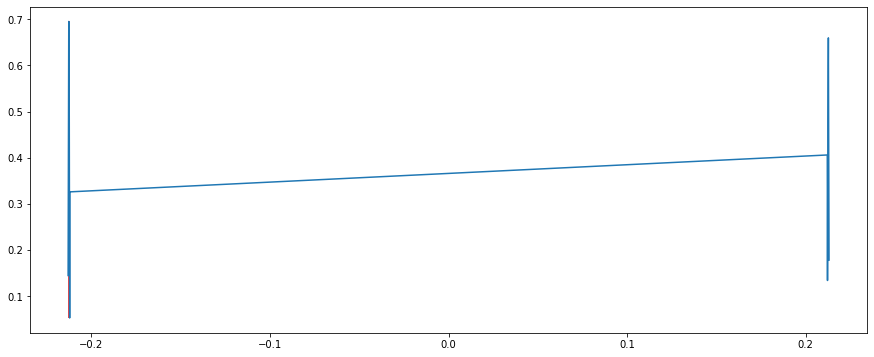

In [21]:
%%time
full_number_corr = batina_recover_weight(secret_number=secret_number, guess_range=guess_range)
ax = full_number_corr.sort_index().plot(figsize=(15,6))
ax.vlines(secret_number, full_number_corr.min(), full_number_corr.max(), color='red')

In [22]:
full_number_corr.sort_values(ascending=False).iloc[:10]

-0.212646    0.695248
 0.212646    0.659633
-0.212402    0.535800
 0.212402    0.475630
 0.212036    0.405729
-0.212036    0.325748
 0.213013    0.177789
-0.213013    0.144349
 0.212158    0.133548
-0.212158    0.052266
dtype: float64

## Analyze with noise - one number

In [23]:
def resize_known_inputs(known_inputs, new_len):
    """
    resize the known input to the new_len
    :param known_inputs: known inputs 
    :param new_len: new size of the know_inputs
    :return: the known
    """
    old_len = len(known_inputs)
    vf = np.vectorize(lambda i: known_inputs[int(i*old_len/new_len)])
    return vf(np.arange(0, new_len))

In [24]:
def add_noise_to_signal(signal, snr, freq):
    """
    add noise to the signal
    :param signal: signal
    :param snr: signal to noise ratio 
    :param freq: frequency of noise 
    :return: signal with noise
    """
    sig_max = signal.max()
    sig_min = signal.min()
    return pd.Series(signal).apply(lambda x: x  +
                                   np.average(np.random.normal(0.0, (sig_max-sig_min)/snr, freq)))

In [25]:
# the noise frequency is 50 times higher than HW signal frequency. Here we also increase
# the sizes of the computation with 
no_noise_secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)

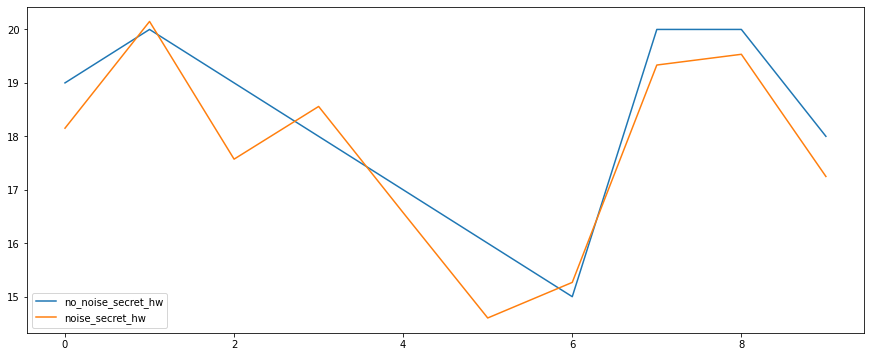

In [26]:
### Add noise to hamming weight of the multiplication of the secret number
signal_to_noise_ratio = 0.5
noise_secret_hw = add_noise_to_signal(signal=no_noise_secret_hw, snr=signal_to_noise_ratio, freq=200)
ax = pd.DataFrame([no_noise_secret_hw, noise_secret_hw], index=['no_noise_secret_hw', 'noise_secret_hw']).T.plot(figsize=(15,6))
ax.legend()

In [27]:
noise_correlations = compute_corr(noise_secret_hw, guess_range, known_inputs, guess_val_size)
print('secret_number =', secret_number)
noise_correlations.sort_values(ascending=False).iloc[:10]

secret_number = -0.21265


 4.50    0.757465
 2.80    0.743161
-4.90    0.722305
 4.90    0.715574
 3.65    0.709059
-0.70    0.691661
-0.35    0.689864
 0.35    0.655447
 0.70    0.639101
-4.50    0.602599
dtype: float64

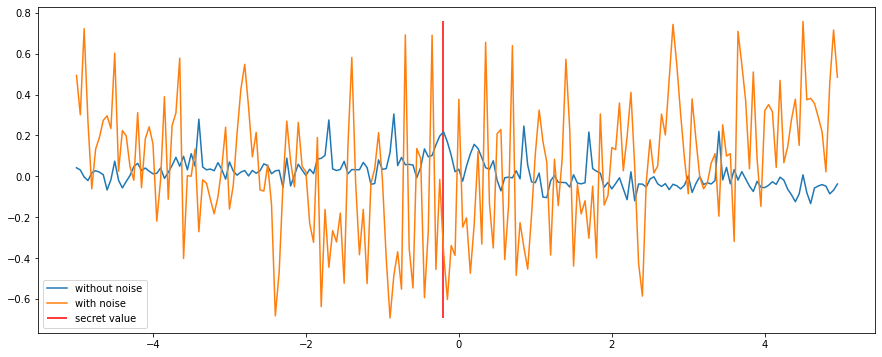

In [28]:
ax = correlations.plot(figsize=(15, 6), label='without noise')
noise_correlations.plot(ax=ax, label='with noise')
ax.vlines(secret_number, 
          min(noise_correlations.min(), correlations.min()),
          max(noise_correlations.max(), correlations.max()), 
          color='red', label='secret value')
ax.legend()

## Analyze with noise - multiple numbers

In [29]:
guess_range = (-5.0, 5.0)
known_input_set = generate_known_inputs(exps=(-2,3), nsize=3000)
precision = 1e-6
n_secret_numbers = 10
secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers*2/4) ),
    np.random.uniform(guess_range[0]*3e-1, guess_range[1]*3e-1, int(n_secret_numbers*1/4)),
    np.random.uniform(guess_range[0]*1e-1, guess_range[1]*1e-1, int(n_secret_numbers*1/4))
))
np.random.shuffle(secret_numbers)
print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))

secret_numbers.shape = (9,)


In [30]:
secret_numbers_hws = {}
for idx in known_input_set.index:
    secret_numbers_hws[idx] = pd.DataFrame(
        columns=secret_numbers, 
        data=np.vectorize(hamming_weight)(np.asarray(known_input_set.loc[idx]).reshape(-1, 1) * secret_numbers))

In [31]:
### Add noise to hamming weight of the multiplication of the secret number
signal_to_noise_ratio = 0.5
noise_secret_numbers_hws = {}
for k in secret_numbers_hws.keys():
    noise_secret_numbers_hws[k] = secret_numbers_hws[k].apply(lambda hw: add_noise_to_signal(signal=hw, snr=signal_to_noise_ratio, freq=200), axis=0)

In [33]:
noise_secret_numbers_hws.keys()

dict_keys([-2, 3])

In [34]:
SECRET_VALUE='secret value'
df_index = [INPUT_ID, LOW_VALUE, HIGH_VALUE, CORRELATION, SECRET_VALUE]

In [152]:
%%time
# start guessing... - without noise first
results = pd.DataFrame()
for value in secret_numbers:
    for kidx in known_input_set.index:
        l, h, c = guess_number_range(secret_numbers_hws[kidx][value], guess_range, precision, known_input_set.loc[kidx])
        pprint('[%.06f] %02d %.06f %.06f %.06f' % (value, kidx, l, h, c))
        results = pd.concat([results, pd.Series([kidx, l, h, c, value], index=df_index)], axis=1, ignore_index=True)

'[2.461531] -2 4.923062 4.923063 0.912202'
'[2.461531] -1 2.461531 2.461532 0.999844'
'[2.461531] 00 2.461531 2.461532 1.000000'
'[2.461531] 01 2.461531 2.461532 1.000000'
'[2.461531] 02 1.230766 1.230766 0.945736'
'[2.461531] 03 4.923062 4.923063 0.945004'
'[3.533028] -2 3.533028 3.533028 1.000000'
'[3.533028] -1 3.533028 3.533028 0.999506'
'[3.533028] 00 3.533028 3.533028 1.000000'
'[3.533028] 01 3.533028 3.533028 1.000000'
'[3.533028] 02 0.883257 0.883257 0.915165'
'[3.533028] 03 3.533028 3.533028 0.997255'
'[0.424809] -2 0.849617 0.849618 0.936660'
'[0.424809] -1 0.849617 0.849618 0.946240'
'[0.424809] 00 1.699234 1.699235 0.980662'
'[0.424809] 01 0.424804 0.424805 0.851194'
'[0.424809] 02 0.424804 0.424805 0.707008'
'[0.424809] 03 1.699215 1.699215 0.576984'
'[1.509192] -2 1.509191 1.509192 0.999711'
'[1.509192] -1 1.509191 1.509192 1.000000'
'[1.509192] 00 1.509191 1.509192 0.999825'
'[1.509192] 01 1.509191 1.509192 0.999753'
'[1.509192] 02 3.018383 3.018384 0.940910'
'[1.509192]

In [158]:
%%time
# start guessing... - with noise
noise_results = pd.DataFrame()
for value in secret_numbers:
    for kidx in known_input_set.index:
        l, h, c = guess_number_range(noise_secret_numbers_hws[kidx][value], guess_range, precision, known_input_set.loc[kidx])
        pprint('[%.06f] %02d %.06f %.06f %.06f' % (value, kidx, l, h, c))
        noise_results = pd.concat([noise_results, pd.Series([kidx, l, h, c, value], index=df_index)], axis=1, ignore_index=True)

'[2.461531] -2 4.923062 4.923063 0.684445'
'[2.461531] -1 2.461531 2.461532 0.700625'
'[2.461531] 00 2.461531 2.461532 0.793582'
'[2.461531] 01 2.461531 2.461532 0.740997'
'[2.461531] 02 0.615383 0.615383 0.715749'
'[2.461531] 03 2.461531 2.461532 0.759744'
'[3.533028] -2 1.766514 1.766514 0.739396'
'[3.533028] -1 0.441628 0.441629 0.732864'
'[3.533028] 00 3.533028 3.533028 0.814130'
'[3.533028] 01 3.533028 3.533028 0.738299'
'[3.533028] 02 3.533028 3.533028 0.784616'
'[3.533028] 03 3.533028 3.533028 0.794457'
'[0.424809] -2 3.398469 3.398470 0.747429'
'[0.424809] -1 1.699214 1.699215 0.515185'
'[0.424809] 00 1.699234 1.699235 0.787166'
'[0.424809] 01 0.424803 0.424804 0.723167'
'[0.424809] 02 0.424808 0.424809 0.711191'
'[0.424809] 03 4.054523 4.054523 0.249206'
'[1.509192] -2 1.509191 1.509192 0.799036'
'[1.509192] -1 1.509191 1.509192 0.799445'
'[1.509192] 00 1.509191 1.509192 0.799920'
'[1.509192] 01 1.509191 1.509192 0.768566'
'[1.509192] 02 1.509191 1.509192 0.746789'
'[1.509192]

## Batina

In [35]:
%%time
# start guessing... - without noise
batina_results = pd.DataFrame(dtype=np.float32, columns=df_index)
for value in secret_numbers:
    s = batina_recover_weight(secret_number=value, guess_range=guess_range)
    s.name = CORRELATION
    df = pd.DataFrame(s).reset_index().rename(columns={'index': LOW_VALUE})
    df[HIGH_VALUE] = df[LOW_VALUE]
    df[INPUT_ID] = 0
    df[SECRET_VALUE] = value
    batina_results = pd.concat([batina_results, df], axis=0, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/home/tvk/programming/others/DPACv4/batina_guess_number.py:39: RuntimeWarning: invalid value encountered in greater_equal
  guess_numbers = y[(lo_range <= y) & (y <= hi_range)]
/home/tvk/programming/others/DPACv4/batina_guess_number.py:39: RuntimeWarning: invalid value encountered in less_equal
  guess_numbers = y[(lo_range <= y) & (y <= hi_range)]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


CPU times: user 19.6 s, sys: 448 ms, total: 20.1 s
Wall time: 20.1 s


In [36]:
%%time
# start guessing... - without noise
noise_batina_results = pd.DataFrame(dtype=np.float32, columns=df_index)
for value in secret_numbers:
    s = batina_recover_weight(secret_number=value, guess_range=guess_range, noise=(add_noise_to_signal, signal_to_noise_ratio, 200))
    s.name = CORRELATION
    df = pd.DataFrame(s).reset_index().rename(columns={'index': LOW_VALUE})
    df[HIGH_VALUE] = df[LOW_VALUE]
    df[INPUT_ID] = 0
    df[SECRET_VALUE] = value
    noise_batina_results = pd.concat([noise_batina_results, df], axis=0, ignore_index=True)

CPU times: user 20 s, sys: 416 ms, total: 20.4 s
Wall time: 20.4 s


In [37]:
from datetime import datetime

TEST_NAME='testset name'

fname = 'final_results-%s.csv' % (datetime.now().strftime("%Y%m%d_%H%M%S"))

batina_results[TEST_NAME] = 'batina_results'
noise_batina_results[TEST_NAME] = 'noise_batina_results'
results.loc[TEST_NAME] = 'results'
noise_results.loc[TEST_NAME] = 'noise_results'
final_results = pd.concat([batina_results, noise_batina_results, results.T, noise_results.T], ignore_index=True, axis=0)
final_results.to_csv(fname)
print('save results in %s' % fname)

NameError: name 'results' is not defined

### Statistics

In [39]:
GUESSED_VALUE = 'guessed value'
ERROR = 'error'
def statistics(df):
    dft = df.T[[SECRET_VALUE, LOW_VALUE, HIGH_VALUE, CORRELATION]].astype(dtype=np.float64)
    dft[GUESSED_VALUE] = (dft[HIGH_VALUE]+dft[LOW_VALUE])/2.0 
    dft[ERROR] = np.abs((dft[GUESSED_VALUE] - dft[SECRET_VALUE])/dft[SECRET_VALUE])    
    best_corr = dft.loc[dft.groupby(SECRET_VALUE)[CORRELATION].idxmax()]
    best_err = dft.loc[dft.groupby(SECRET_VALUE)[ERROR].idxmin()]
    return best_corr.T, best_err.T

In [180]:
best_corr, best_err = statistics(results)
noise_best_corr, noise_best_err = statistics(noise_results)

In [40]:
batina_best_corr, batina_best_err = statistics(batina_results.T)
noise_batina_best_corr, noise_batina_best_err = statistics(noise_batina_results.T)

In [ ]:
(batina_best_corr.T[ERROR] < 1e-3).value_counts()

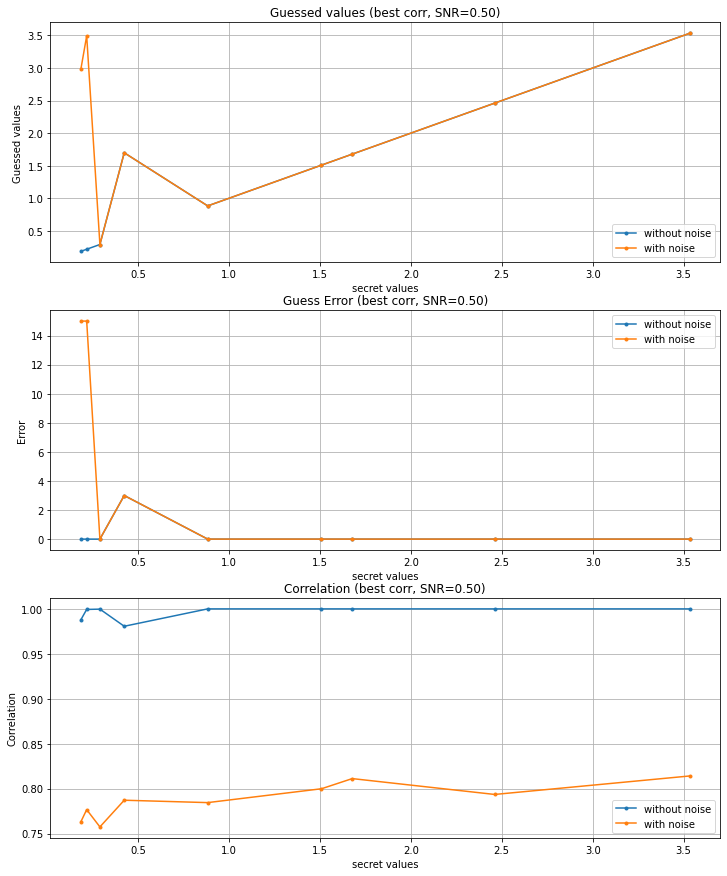

In [213]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
df = noise_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
df = noise_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()

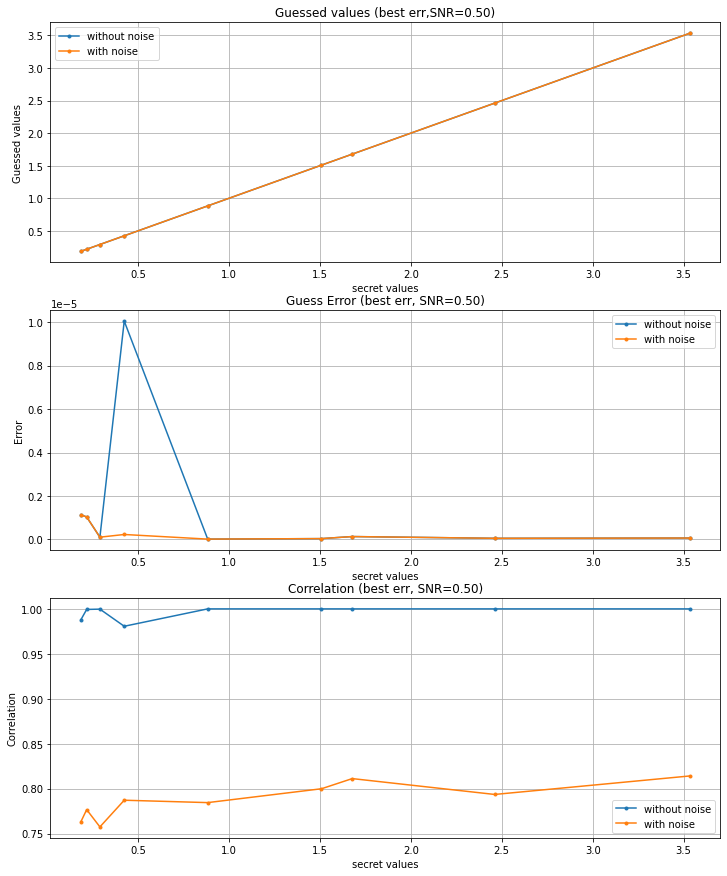

In [214]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = best_err.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_best_err.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (best err,SNR=%0.2f)' % signal_to_noise_ratio)


df = best_err.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
df = noise_best_err.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (best err, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
df = noise_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (best err, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()

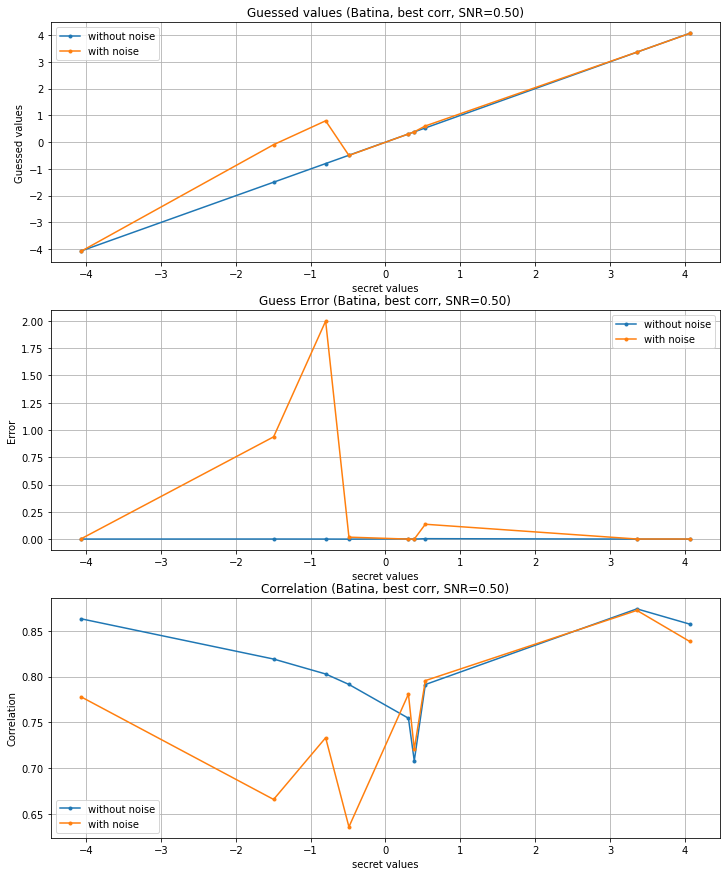

In [41]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = batina_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_batina_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (Batina, best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = batina_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
df = noise_batina_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (Batina, best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = batina_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
df = noise_batina_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (Batina, best corr, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()

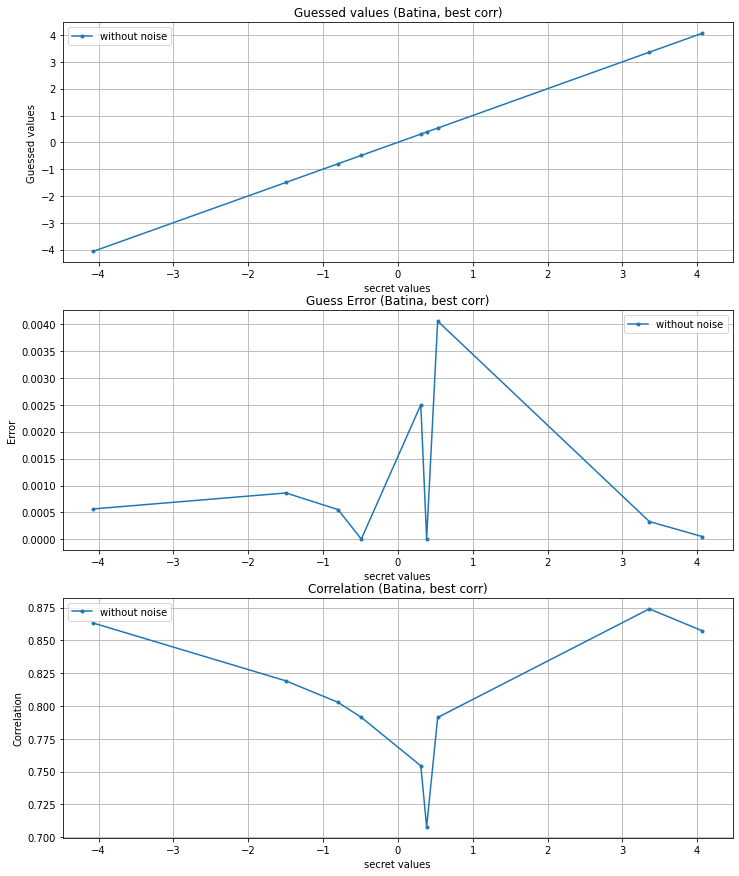

saved picture in nhw-20200607_171501034700.jpg


In [42]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = batina_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (Batina, best corr)')

df = batina_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (Batina, best corr)')

df = batina_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (Batina, best corr)')

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()
print('saved picture in %s' % fname)